In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from commons.utils import save, load
from library import *
from process_library_terms import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
positions, vs, deltat, dims = load('Matt/sim_n64_v03.npy', 4)
deltat
print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

(1024, 2, 128) (1024, 2, 128) 0.003662109375 [  1 128]
[  1   1 128]


0
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120


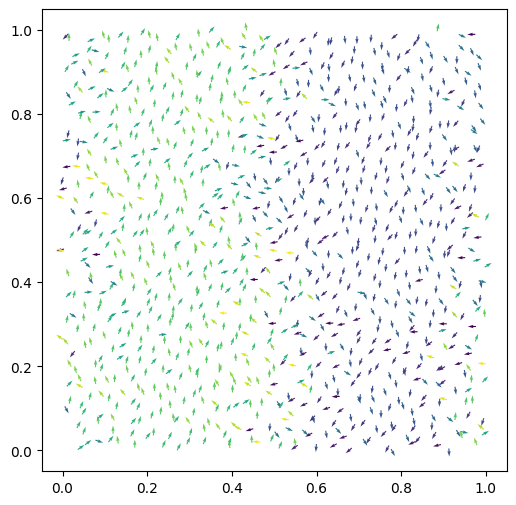

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

vid_file = 'Matt/sim_n64_v03.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [5]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 0.05
kernel_sigma = 0.05 # 0.02
cg_res = 256
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
v_est = np.mean(np.abs(vs))*2**0.5
print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 0.3
dom_time = 40
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_weights(m=8, qmax=0)
srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_gauss1024.npy', srd)

0.8065285682631045
 

         16873444 function calls (16201189 primitive calls) in 649.501 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4260  517.122    0.121  517.134    0.121 coarse_grain_utils.py:267(poly_coarse_grain_time_slices)
      645   88.502    0.137   88.638    0.137 {built-in method time.sleep}
    18180   13.794    0.001   13.807    0.001 diff.py:479(_apply_to_array)
    133/2    6.322    0.048    0.000    0.000 {method 'control' of 'select.kqueue' objects}
    26640    4.136    0.000  575.700    0.022 process_library_terms.py:399(eval_term)
    79920    3.386    0.000    4.665    0.000 _function_base_impl.py:5078(trapezoid)
    79920    1.446    0.000    1.498    0.000 polynomial.py:672(polyval)
    26640    1.388    0.000  590.432    0.022 process_library_terms.py:377(eval_on_domain)
   201709    1.354    0.000    1.354    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     4260    1.042    0.000  570.605    0.134 pro

In [6]:
# %%prun # profiling

# data_dict = {}
# data_dict['v'] = vs
# v_obs = Observable(string='v', rank=1)
# observables = [v_obs]

# # fix random seed
# np.random.seed(1)

# # initial setup of dataset
# corr_L = 0.05#0.3
# kernel_sigma = 0.02#0.05
# cg_res = 256
# srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
#                 irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
# v_est = np.mean(np.abs(vs))*2**0.5
# print(v_est)

# # initialize libraries, domains, and weights
# #srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
# srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
# #srd.make_libraries(max_complexity=6, max_observables=4)

# dom_width = 0.3
# dom_time = 20
# srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
# srd.make_weights(m=8, qmax=1)
# srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
# srd.make_library_matrices(debug=False)

# save('Q_gauss1024.npy', srd.dxs, srd.libs)

In [7]:
from commons.identify_models import *
import copy

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    init = Initializer(method='combinatorial', start_k=2)
    #init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
#eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in range(len(irreps))], 
reg_opts_list, threshold=3e-1, experimental=True)
#, max_equations=10)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
[0.02 s]
Identified model: ρ + -0.000989 · ρ · ρ = 0 (order 2, train res 4.80e-02, test res 4.51e-02)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.00 s]
Identified model: ∂α² ρ = 0 (order 3, train res 1.39e-01, test res 9.84e-02)
[0.13 s]
Identified model: 1 · ∂t ρ + ∂α ρ[v_α] = 0 (order 3, train res 6.72e-07, test res 3.52e-07)
[0.35 s]
Identified model: -0.729 · ρ + ρ[v_α · v_α] = 0 (order 3, train res 2.78e-01, test 

In [8]:
print(excluded_terms)

{ρ · ρ · ρ[v_α], ∂α ∂γ ρ[v_β · v_γ], ∂t² ∂α² ρ, ∂α ρ · ∂β² ρ, ρ · ∂α ρ · ∂β ρ, ∂α ρ · ∂t ρ[v_α], ∂t ρ · ∂t ρ[v_α], ∂α ∂β ∂γ ∂δ ρ, ρ · ρ · ∂α ρ, ρ · ∂t ρ[v_α], ∂t³ ρ[v_α], ρ · ρ · ∂α² ρ, ρ[v_α] · ρ[v_α], ∂α ∂β ∂γ ρ, ∂α ∂β ρ · ∂t ρ, ∂t ∂β² ρ[v_α], ∂β ρ · ∂α ρ[v_β], ∂t ρ · ∂α ρ[v_α], ρ · ρ[v_α], ∂β ρ · ∂β ρ[v_α], ρ · ∂α ρ · ρ[v_α], ρ · ∂t ρ[v_α · v_α], ρ · ρ · ∂α ρ[v_β], ρ[v_α] · ∂β ρ[v_γ], ρ · ρ · ρ[v_α · v_α], ∂t² ∂α ρ[v_α], ∂t ∂α ρ[v_α], ∂α ∂β² ρ, ∂α ρ · ∂β ρ[v_β], ρ · ρ · ∂t ∂α ρ, ∂α ∂β ρ[v_α · v_β], ∂t ∂α² ρ, ρ · ∂α² ρ, ∂t ∂α ∂β ρ[v_γ], ρ · ρ · ρ · ρ[v_α], ∂t ∂α ∂β² ρ, ∂α² ∂β² ρ, ∂α ∂β ρ[v_γ · v_γ], ∂α ρ[v_β · v_γ · v_γ], ρ · ρ · ρ · ρ, ∂α ∂β ∂γ ρ[v_γ], ∂α ρ · ∂β ρ[v_γ], ρ · ∂t² ρ, ρ · ρ · ∂α ρ[v_α], ∂t ρ[v_α], ∂α ρ · ∂β ρ, ρ · ρ · ∂α ∂β ρ, ∂α² ρ[v_β · v_β], ρ · ρ[v_α · v_α], ρ · ρ[v_α] · ρ[v_β], ∂α ρ · ∂t ∂α ρ, ρ · ∂α ∂β ρ, ∂t ∂α ∂β ∂γ ρ, ρ · ρ · ρ · ∂t ρ, ρ · ∂t ∂α ∂β ρ, ρ · ∂t ∂α ρ, ρ · ∂α ∂β ρ[v_β], ∂α ∂β ∂γ² ρ, ∂t ∂α ρ[v_β], ρ · ∂t³ ρ, ρ · ∂t ∂α ρ[v_β], ρ · ∂α ρ[v_β], ∂t ρ[v_α ·

In [9]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'ρ · ∂t ρ\[v_α\]')))

0 ρ · ∂α ρ 1085571.0618450337 3
1 ρ · ∂α ∂β² ρ 434228424.73801345 5
2 ρ · ∂t ∂α ρ 17510881.48515466 4
3 ρ · ∂t² ∂α ρ 282460523.4649338 5
4 ρ · ρ[v_α] 731015.1123880195 3
5 ρ · ∂β² ρ[v_α] 15135502.002550784 5
6 ρ · ∂α ∂β ρ[v_β] 15135502.002550784 5
7 ρ · ∂t ρ[v_α] 610360.7380030318 4
8 ρ · ∂t² ρ[v_α] 9845467.442911942 5
9 ρ · ∂β ρ[v_α · v_β] 527564.3136614872 5
10 ρ · ∂α ρ[v_β · v_β] 527564.3136614872 5
11 ρ · ρ[v_α · v_β · v_β] 355286.93653138686 5
12 ∂α ρ 1060.1279900830407 2
13 ∂β ρ · ∂α ∂β ρ 22477427.107150152 5
14 ∂α ρ · ∂β² ρ 22477427.107150152 5
15 ∂α ρ · ∂t ρ 906434.3551484054 4
16 ∂α ρ · ∂t² ρ 14621304.053646676 5
17 ∂β ρ · ∂α ρ[v_β] 783475.0642999025 5
18 ∂α ρ · ∂β ρ[v_β] 783475.0642999025 5
19 ∂β ρ · ∂β ρ[v_α] 783475.0642999025 5
20 ∂β ρ · ρ[v_α · v_β] 527607.7202974767 5
21 ∂α ρ · ρ[v_β · v_β] 527607.7202974767 5
22 ∂β² ρ · ρ[v_α] 15136124.644848421 5
23 ∂α ∂β ρ · ρ[v_β] 15136124.644848421 5
24 ∂α ∂β² ρ 424051.19603321626 4
25 ∂t ρ · ∂t ∂α ρ 14621304.053646676 5
26 ∂t ρ · ρ[

In [10]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'∂t ∂α ρ\[v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ∂α² ρ')))

0 ρ 1024.0 1
1 ρ · ρ 1048576.0 2
2 ρ · ∂α² ρ 21711421.236900672 4
3 ρ · ∂t ρ 875544.0742577332 3
4 ρ · ∂t ∂α² ρ 350217629.7030932 5
5 ρ · ∂t² ρ 14123026.173246695 4
6 ρ · ∂t³ ρ 227812481.58102012 5
7 ρ · ∂α ρ[v_α] 756775.1001275392 4
8 ρ · ∂t ∂α ρ[v_α] 12207214.760060634 5
9 ρ · ρ[v_α · v_α] 509627.432384175 4
10 ρ · ∂t ρ[v_α · v_α] 425495.6905641067 5
11 ∂α ρ · ∂α ρ 1123871.3553575077 4
12 ∂α ρ · ∂t ∂α ρ 18128687.102968108 5
13 ∂α ρ · ρ[v_α] 756806.232242421 4
14 ∂α ρ · ∂t ρ[v_α] 631895.0218796441 5
15 ∂α² ρ 21202.559801660813 3
16 ∂α² ρ · ∂t ρ 18128687.102968108 5
17 ∂α² ∂β² ρ 8481023.920664325 5
18 ∂t ρ 855.0235100173176 2
19 ∂t ρ · ∂t ρ 731065.2026823339 4
20 ∂t ρ · ∂t² ρ 11792499.424527181 5
21 ∂t ρ · ∂α ρ[v_α] 631895.0218796441 5
22 ∂t ρ · ρ[v_α · v_α] 425530.69925608445 5
23 ∂t ∂α ρ · ρ[v_α] 12207716.938861486 5
24 ∂t ∂α² ρ 342009.4040069269 4
25 ∂t² ρ 13792.017747311225 3
26 ∂t² ∂α² ρ 5516807.098924489 5
27 ∂t³ ρ 222473.12654396496 4
28 ∂t⁴ ρ 3588618.6445704107 5
29 ρ[v_α] · ρ[

In [11]:
print(reg_results[2].all_lambdas, reg_results[2].all_lambdas_test)

[1.322e+00 6.719e-07 6.536e-07 6.510e-07 6.477e-07] [6.726e-01 1.761e-07 1.884e-07 1.800e-07 1.676e-07]


In [12]:
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=2)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

#remove_terms = [7] # rho * dt rho[v_i]
remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

∂α² ρ + 0.0005419387601125464 · ∂α² ∂β² ρ + -0.06645035446177779 · ∂t² ρ + 0.06361336665877207 · ∂α ∂β ρ[v_α · v_β] = 0 ; residual: 0.14092593850063534


In [13]:
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=2)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 41 # dt rho[v_i]

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

∂α ρ + 0.0673994725808827 · ∂t ρ[v_α] + 0.07579842199135775 · ∂β ρ[v_α · v_β] = 0 ; residual: 0.1805265972482899


In [14]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

NameError: name 'find_term' is not defined